# Math Modeling - Final Project

Computational Science 520

Professor Allali

Celeste Manughian-Peter


## Background

In recent years there has been a rising popularity in eating a "plant-based" diet (see figure below) [8], due to increased prevalance of chronic conditions stemming from lifelong adherance to the Standard American Diet (SAD). Maintaining a healthy diet regimine like the Medteranian, Paleo, Autoimmune Protocol, or other anti-inflammatory, produce-rich diet is important for maintaining overall health. Vegetable-rich diets are also known to prevent and reverse chronic diseases that stem from a multitude of factors, including eating a diet rich in processed foods like the SAD.

One practical question that arises when people switch from the SAD full of cheap processed and pre-packaged foods to a healthier one filled with fresh foods is, how much (extra) is this going to cost me? 
Another practical question when switching to a non-SAD diet is, can I meet all of my reccommended dietary allowance for the necessary nutrients?

This program aims to come up with a list of foods within a certain diet regimine that meet recommended daily allowance for nutrients and recommmended daily calories for gender, age, and activity, while minimizing cost.

<img src="./plantbasedinterest.png">

Future work for this would include adding a constraint to not only meet RDA but maximize nutrient density, as well as programmatically (not manually) restrict food categories based on inputted diet. Incorporating seasonality of foods into the model and having an input for obtaining prices by user's region would be beneficial (and easily doable) as well. We could also extend this to add constraints for diet paletability or put extra amount limits on things like spices and herbs, since no one eats those in large amonunts on their own.

## Overview

### Data 
Data required for this program

* Nutrient profile for each food
* Calorie information for each food
* Price data for each food
* Recommended daily allowance and calories for given person

### Variables 

* Amount of each food product - this is what we solve for 
* Budget - this is a constraint
* RDA, RDA for person - this is determined by an individual's parameters
* Diet Model
 * For example run I choose Paleo diet

### Optimization

This program could've been written to optimize over what is most restrictive to a person = budget or nutrient density, or include constraints on allergens like gluten, citrus, and limits on certain levels like sugar amounts. Due to time constraints, I chose to focus on one diet, minimizing cost, maintaining recommended daily allowance (RDA) and recommended daily calorie (RDC) levels, under certain dietary restrictions.

## The Data

### Data source investigation

Data required for this program

* Nutrient profile for each food
* Calorie information for each food
* Price data for each food
* Recommended daily allowance and calories for given person

### Nutrient profile and calorie data

After searching far and wide, the most comprehensive data set that I could find came from the United States Department of Agriculture (USDA). FoodData central[1] is a food and nutrient data system that hosts several USDA food composition databases, including the Food and Nutrient Database for Dietary Studies (FNDDS), Standard Reference (SR) Legacy, and the USDA Branded Food Products Database. FoodData Central also includes expanded nutrient content information as well as links to diverse data sources that offer related agricultural, environmental, food, health, dietary supplement, and other information

After exploring all of the databases there, I finally landed on something I could use for nutrient composition, called Composition of Foods Raw, Processed, Prepared USDA National Nutrient Database for Standard Reference, Release 28 [2]. This database provides a breakdown of many nutrients for many different types of foods, for a given amount, as well as the kCal for consuming that amount of that food. This takes care of my first two data sets required to solve this problem.


### Price data

For this program a price for each food item is needed for the objective of minimizing price. The Quarterly Food-at-Home Price Database (QFAHPD) [4] from the USDA provides food price data to support research on the economic determinants of food consumption, diet quality, and health outcomes. This price data outlines average price per 100g of food for different food categories in different geographical regions. To get a price for each food item listed in the nutrient composition database, I manually went through each food category and mapped the food categories listed in the nutrient database to those in the food price data set (more on this later).

### Data for recommended daily allowance and calories

The data for recommended daily allowance and calorie intake was found summarized on health.gov [5].  The Institute of Medicine provides dietary reference intakes in <i>The essential guide to nutrient requirements. Washington (DC): The National Academies Press; 2006.</i> This was copy and pasted out of each table on the Appendix 7 web page into a text file and manually reformatted as a table so it could be read in by <b>pandas</b>.



### Data Processing and Exploration

#### A closer look at the acquired data


FoodData Central is an integrated data system contains five distinct sources of food and nutrient composition data, each with a unique purpose. Three of these data types are well-established and familiar to many users: the National Nutrient Database for Standard Reference, the Food and Nutrient Database for Dietary Studies, and the USDA Global Branded Food Products Database. The other two data sources—Foundation Foodsand Experimental Foods—represent “a bridge to the future” in food and nutrient composition. Foundation Foodsincludes nutrient values as well as extensive underlying metadata on commerciallyavailablefoods.

ABBREV.csv is the main nutrient composition database used. However, after processing was done I had renamed it data.csv. The processing that was done to this was 

* Mapping food group code to the actual food group description, using ./data/FD_GROUP.txt. This is shown in another processing notebook. 
* The ABBREV data was originally downloaded as a Microsoft Access Database file, which I processed so I could read into pandas dataframe. For processing .accdb files, first replace ~^~ with ; then replace ~ with nothing Then we can ingest it as a csv with sep=";" into pandas df. 
* The number of units and unit name per item is also separated and cast to their appropriate respective data types. 

The calorie needs and RDA data tables needed to be heavily processed as well. They offered age ranges for each calorie amount, and RDA limits. This needed to be expanded to hold a calorie amount for each discrete age and activity level.

Next, the food price data offers average price per 100g unit of food for different food categories. These food categories needed to be manually mapped to the food group descriptions in the nutrient composition database. 

The following section shows a subset of the  data preprocessing that was done. The rest can be found in "FoodData Central Data Processing" notebook if interested. 

In [357]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import seaborn as sns
import ortools
from ortools.linear_solver import pywraplp

In [358]:
# Unit conversion
G_TO_MG = 1000
MG_TO_G = .001

Reading in the data for nutrient profiles (food_item_properties), RDC (calorie_needs), RDA (RDA), and price (qfahpd2*.csv)

In [359]:
# Nutrient, price, and RDA data 
food_item_properties = pd.read_csv("./data/data.csv")
calorie_needs = pd.read_csv("./data/calorie_needs.csv")
food_group_needs = pd.read_csv("./data/est_food_group_needs.csv", sep='\t')
RDA = pd.read_csv("./data/RDA_fixed.csv")

print("Format of nutrient profile data:")
display(food_item_properties.head())
print("Initial format of calorie intake data:")
display(calorie_needs.head())
print("Initial format of RDA data:")
display(RDA.head())
print("Initial format of price data:") # TODO
# display(prices.head())
print("\n\n")

Format of nutrient profile data:


,NDB No,Shrt Desc x,Water g,Energ Kcal,Protein g,Lipid Tot g,Ash g,Carbohydrt g,Fiber TD g,Sugar Tot g,...,FdGrp Cd,Long Desc,Shrt Desc y,FdGrp Desc,Seq,Amount,Unit,isDryFood,price,FdGrp Price
0,1003,"BUTTER OIL,ANHYDROUS",0.24,876,0.28,99.48,0.00,0.00,0.0,0.00,...,100,"Butter oil, anhydrous","BUTTER OIL,ANHYDROUS",Dairy and Egg Products,1,1.0,tbsp,False,0.156509,0.439291
1,1004,"CHEESE,BLUE",42.41,353,21.40,28.74,5.11,2.34,0.0,0.50,...,100,"Cheese, blue","CHEESE,BLUE",Dairy and Egg Products,1,1.0,oz,False,1.286240,0.439291
2,1005,"CHEESE,BRICK",41.11,371,23.24,29.68,3.18,2.79,0.0,0.51,...,100,"Cheese, brick","CHEESE,BRICK",Dairy and Egg Products,1,1.0,"cup, diced",False,0.078717,0.439291
3,1006,"CHEESE,BRIE",48.42,334,20.75,27.68,2.70,0.45,0.0,0.45,...,100,"Cheese, brie","CHEESE,BRIE",Dairy and Egg Products,1,1.0,oz,False,3.116838,0.439291
4,1007,"CHEESE,CAMEMBERT",51.80,300,19.80,24.26,3.68,0.46,0.0,0.46,...,100,"Cheese, camembert","CHEESE,CAMEMBERT",Dairy and Egg Products,1,1.0,oz,False,1.256646,0.439291


Initial format of calorie intake data:


,AGE,Sedentary,Moderately_active,Active,Gender
0,2,1000,1000,1000,Female
1,3,1000,1000,1000,Female
2,4,1200,1200,1200,Female
3,5,1200,1200,1200,Female
4,6,1200,1200,1200,Female


Initial format of RDA data:


,index,"1,000 kcal","Added sugars, % kcal",Age,"Calcium, mg",Calorie level(s) assessed,"Carbohydrate, % kcal","Carbohydrate, g","Choline, mg","Copper, mcg",...,"Total fat, % kcal","Vitamin A, mcg RAE","Vitamin B12, mcg","Vitamin B6, mg","Vitamin C, mg","Vitamin D, IU","Vitamin E, mg AT","Vitamin K, mcg",Vitamins,"Zinc, mg"
0,1,16.8,<10%,1,700,NaN,45-65,130,200,340,...,30-40,300,0.9,0.5,15,600,6,30,NaN,3
1,1,16.8,<10%,2,700,NaN,45-65,130,200,340,...,30-40,300,0.9,0.5,15,600,6,30,NaN,3
2,1,16.8,<10%,3,700,NaN,45-65,130,200,340,...,30-40,300,0.9,0.5,15,600,6,30,NaN,3
3,2,19.6,<10%,4,"1,000",NaN,45-65,130,250,440,...,25-35,400,1.2,0.6,25,600,7,55,NaN,5
4,2,19.6,<10%,5,"1,000",NaN,45-65,130,250,440,...,25-35,400,1.2,0.6,25,600,7,55,NaN,5


Initial format of price data:





##### Visual Overview of Food Groups in the Composition of Foods Raw, Processed, Prepared USDA National Nutrient Database for Standard Reference, Release 28

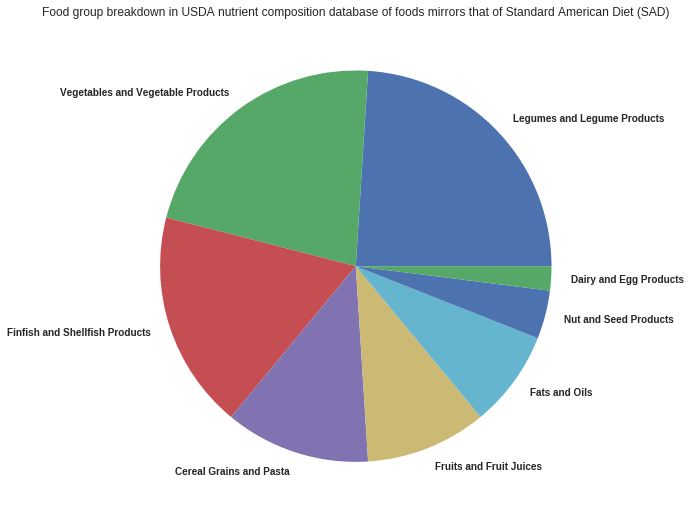

In [392]:
# Pie plot for higher level food groups in nutrient profile data
plt.figure(figsize=(17,9))
p = plt.pie(food_item_properties['FdGrp Desc'].value_counts(), 
        labels = food_item_properties['FdGrp Desc'].value_counts().index.values)
t = plt.title("Food group breakdown in USDA nutrient composition database of foods mirrors that of Standard American Diet")

/home/celeste/.local/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


<Figure size 1152x576 with 0 Axes>

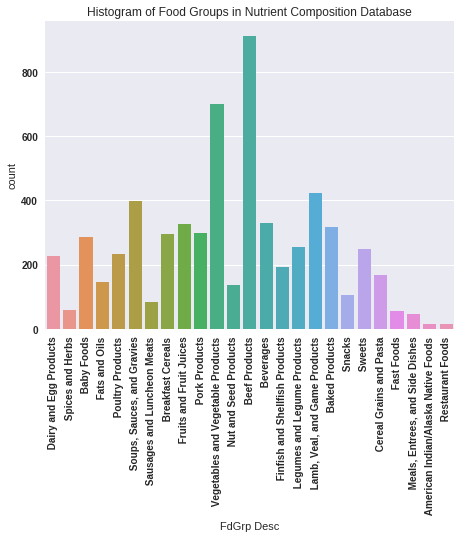

In [361]:
p = plt.figure(figsize=(16,8))
g = sns.factorplot("FdGrp Desc", data=food_item_properties, aspect=1.5, kind="count")
t = g.set_xticklabels(rotation=90)
p = plt.title("Histogram of Food Groups in Nutrient Composition Database")



#### Data Preprocessing and Helper Functions



In [362]:
# RDA Data Preprocessing
RDA.drop(columns=[RDA.columns[0], RDA.columns[5], RDA.columns[-2]], inplace=True)
# Rename RDA columns to match food item property columns 
RDA.columns= [" ".join(z.strip().replace(",", "").split()) for z in RDA.columns.values]
# Lets look at the columns well analyze
# print(RDA.columns)
# print(food_item_properties.columns)
# Lets just look at these for now, we can manually get the nutrients that dont match because of syntax a bit later
nutrients_to_check = [z for z in RDA.columns.values if z in food_item_properties.columns.values ]
#                       and
#                      z != 'Riboflavin mg'  and z != 'Niacin mg' and z !='Manganese mg' and z != 'Thiamin mg']
print(nutrients_to_check)
nutrients_to_check.append('Age')
nutrients_to_check.append('Gender')

def get_RDA_RDC_for_person(age=26,gender='Female',activity='Sedentary', diet='paleo', calorie_needs=calorie_needs, RDAdf=RDA, nutrients_to_check=nutrients_to_check): 
    # TODO: 5 duplicates for age - for now just get first one 
    rda_for_person = RDA[(RDA.Age == age) & (RDA.Gender == gender)].iloc[0]
    calorie_needs_for_person = calorie_needs[(calorie_needs.AGE == age) & (calorie_needs.Gender == gender)][['AGE', 'Gender', activity]]
    return rda_for_person[nutrients_to_check], calorie_needs_for_person[activity].values[0]

['Calcium mg', 'Iron mg', 'Magnesium mg', 'Manganese mg', 'Niacin mg', 'Phosphorus mg', 'Potassium mg', 'Protein g', 'Riboflavin mg', 'Sodium mg', 'Thiamin mg', 'Zinc mg']


Preprocess the nutrient composition data and limit the foods to align with anti-inflammatory diet.

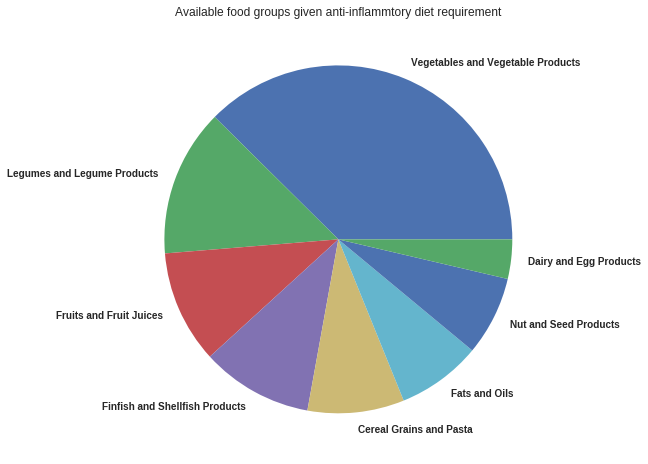

In [363]:
# Standard Cleanup
# Remove whitespace
food_item_properties['FdGrp Desc'] = food_item_properties['FdGrp Desc'].apply(lambda z : z.strip())
# Replace NaNs with 0
food_item_properties= food_item_properties[~food_item_properties['FdGrp Price'].isna()]
food_item_properties = food_item_properties.fillna(0)

# Nutrient Composition Data Preprocessing
constraint_cats = ['Vegetables and Vegetable Products', 
                   'Fruits and Fruit Juices',
                   'Fats and Oils',
                   'Finfish and Shellfish Products',
                   'Nut and Seed Products',
                   'Dairy and Egg Products',
                   'Legumes and Legume Products',
                   'Cereal Grains and Pasta'
                  ]

# Lets drop the food groups that do not fit into our diet
# Keep only the food groups listed above
food_item_properties = food_item_properties[food_item_properties['FdGrp Desc'].isin(constraint_cats)]
# Let's further refine by extracting specific foods like those relating to dairy
# Take out dairy
food_item_properties= food_item_properties[~((food_item_properties['FdGrp Desc'] == 'Dairy and Egg Products') & 
                      (food_item_properties['Shrt Desc x'].str.lower()
                      .str.contains('cheese|inst|dairy|butter|hydr|acid|substitute|milk|velveeta|ice crm')))]
# Take out sweetened fruit
food_item_properties= food_item_properties[~((food_item_properties['FdGrp Desc'] == 'Fruits and Fruit Juices') & 
                      (food_item_properties['Shrt Desc x'].str.lower()
                      .str.contains('swt|syrup|stwnd|w/ sugar|ocean spray|bolthouse|w/ sucralose|naked')))]



# Let's see what the food group composition looks like now
# Pie plot for higher level food groups in nutrient profile data given diet restrictions
plt.figure(figsize=(15,8))
p = plt.pie(food_item_properties['FdGrp Desc'].value_counts(), 
        labels = food_item_properties['FdGrp Desc'].value_counts().index.values)
t = plt.title("Available food groups given anti-inflammtory diet requirement")

Price data processing involved mapping the Foodgroup Description form data to the price category to assign a price to each price data food group and looking through the Quarterly Food-at-Home Price Database documentation documentation [6] to find the units that the prices were corresponding to. They calculate the price per 100 grams (unit value) for each purchase of each food item [6]. For dry weights, they use a conversion of 28.35 grams per ounce, and a conversion factor of 29.57 grams per ounce for liquids. In some cases, however, only the number of items purchased (e.g., ears of corn) is reported. In these cases, they used the USDA National Nutrient Database for Standard Reference (Release 20) to convert the unit counts to weight, assuming the food was medium-sized (if there are multiple sizes in the database). Although it was possible to convert most unit counts to gram weights using this approach, not all purchases reported only as counts were convertible. Those food items that were not converted were excluded from the price calculations.

In [364]:
# Price data Preprocessing

# Lets get the latest Los Angeles (15) prices for each category and manually average them for the
# FdGrp_Desc categories 
qrs_fns = [qr for qr in os.listdir("./data") if "qfahpd2" in qr and 'lock' not in qr]
qrs = []
price_df = pd.DataFrame(columns=['qr', 'year', 'price', 'marketgroup'])
for i, qr in enumerate(qrs_fns):
    print(qr)
    xls = pd.ExcelFile("./data/"+qr)
    for sht in xls.sheet_names:
        if sht.isnumeric():
            print(sht)
            xldf = pd.read_excel("./data/"+qr, sheet_name=sht)
            qrcat_sheets.append(xldf)
            latest_year = np.unique(xldf.year)[-1]
            marketgroup = 15
            # Median price for this food group for specified marketgroup region
            median_fdgrp_sht_price = xldf[(xldf.year == latest_year) & (xldf['marketgroup'] == marketgroup)].price.median()
            price_df= price_df.append({'qr': qr, 'year': latest_year, 'sheet': sht,
                                       'price': median_fdgrp_sht_price, 'marketgroup': 15},
                                      ignore_index=True)


# Map food groups from price data to food groups from nutrient composition data
def get_price_for_fdgrp(fdgrp, price_df):
    if fdgrp.strip() == 'Baby Foods':
        return price_df[price_df.sheet == '1'].price.values[0]
    elif fdgrp.strip() == 'Fruits and Fruit Juices':
        return price_df[price_df.sheet.isin(['1','2','3'])].price.values.mean()
    elif fdgrp.strip() == 'Vegetables and Vegetable Products':
        return price_df[price_df.sheet.isin(['4','5','6','7','8','9','10'])].price.values.mean()
    elif fdgrp.strip() == 'Vegetables and Vegetable Products':
        return price_df[price_df.sheet.isin(['4','5','6','7','8','9','10', '11','12','13'])].price.values.mean()
    elif fdgrp.strip() == 'Legumes and Legume Products':
        return price_df[price_df.sheet.isin(['14','15'])].price.values.mean()
    elif fdgrp.strip() == 'Breakfast Cereals':
        return price_df[price_df.sheet.isin(['16', '18', '19', '21'])].price.values.mean()
    elif fdgrp.strip() == 'Cereal Grains and Pasta':
        return price_df[price_df.sheet.isin(['16', '19'])].price.values.mean()
    elif fdgrp.strip() == 'Dairy and Egg Products':
        return price_df[price_df.sheet.isin(['24','25','26','27', '37'])].price.values.mean()
    elif fdgrp.strip() == 'Beef Products':
        return price_df[price_df.sheet.isin(['28', '29', '30'])].price.values.mean()
    elif fdgrp.strip() == 'Lamb, Veal, and Game Products':
        return price_df[price_df.sheet.isin(['28', '29'])].price.values.mean()
    elif fdgrp.strip() == 'Pork Products':
        return price_df[price_df.sheet.isin(['28', '29'])].price.values.mean()
    elif fdgrp.strip() == 'Nut and Seed Products':
        return price_df[price_df.sheet.isin(['35', '36'])].price.values.mean()
    elif fdgrp.strip() == 'Fats and Oils':
        return price_df[price_df.sheet.isin(['38', '39'])].price.values.mean()
    elif fdgrp.strip() == 'Beverages':
        return price_df[price_df.sheet.isin(['41', '42', '43'])].price.values.mean()
    elif fdgrp.strip() == 'Baked Products':
        return price_df[price_df.sheet.isin(['46'])].price.values.mean()
    elif fdgrp.strip() == 'Sweets':
        return price_df[price_df.sheet.isin(['44','45','46'])].price.values.mean()
    elif fdgrp.strip() == 'Soups, Sauces, and Gravies':
        return price_df[price_df.sheet.isin(['49'])].price.values.mean()
    elif fdgrp.strip() == 'Snacks':
        return price_df[price_df.sheet.isin(['50'])].price.values.mean()
    elif fdgrp.strip() == 'Sausages and Luncheon Meats':
        return price_df[price_df.sheet.isin(['51', '52'])].price.values.mean()
    elif fdgrp.strip() == 'Finfish and Shellfish Products':
        return price_df[price_df.sheet.isin(['51', '52'])].price.values.mean()
    else:
        return 1
    
# This price data was written to data.csv so we don't have to rerun it on the original data
# data['FdGrp_Price'] = data.FdGrp_Desc.apply(get_price_for_fdgrp, price_df=price_df)

Additional optional preprocessing could be replacing acronyms in nutrient database. This can be done with the following data file.

In [384]:
# abv = pd.read_csv("./data/abbreviations.csv")

## The Linear Program

### Variable Definitions

In [365]:
age=26
gender='Female'
activity='Sedentary'
diet='Paleo'

In [366]:
# Let's get my RDA 
my_RDA, my_RDC = get_RDA_RDC_for_person(age=26, gender='Female', activity="Moderately_active")

In [367]:
food_item_properties_org = food_item_properties 

In [379]:
# Define LP solver
# The primary OR-Tools linear optimization solver is Glop, Google's linear programming system
# Name and type of solver
solver = pywraplp.Solver("Minimum nutrients for food",
                         pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)  

# Define amounts of each food item as variables in our linear program
food_item_properties = food_item_properties_org.sample(n=50, replace=True)
units_fooditems = [solver.NumVar(0, .5, 'Number of 100g units of ' + fooditem[1]['Shrt Desc x']) for fooditem in food_item_properties.iterrows()]

### Objective Function

We are looking to find the proportions of each food item in our daily "mixture" to satisfy RDA, RDC, variety, and diet requirements. Our objective function will be to minimize overall cost.

Here we will minimize the sum of price per 100g of food * units of 100g of for, for each food item in the nutrient profile database. Remember we had taken out a few categories of food items to restrict the diet.

In [380]:
solver.Minimize(sum([fooditem[1]['FdGrp Price']*units_fooditem for fooditem, units_fooditem in zip(food_item_properties.iterrows(), units_fooditems)]))

### Constraints

#### Diet "Constraint"
This constraint is a general constraint, in that we will not include certain food groups for the diet pattern instead of seeting the amounts equal to zero.

#### RDA Constraint

For this constraint we will limit the sum of each nutrient across foods to be +/- E% of the RDA value for that nutrient.

In [381]:
# The sum of nutrients should be within E percent of the RDA
E = 0
for nutrient in my_RDA.items():
    if nutrient[0] != 'Gender' and nutrient[0] != 'Age':
        if isinstance(nutrient[1], str):
            rda_nut = int(nutrient[1].replace(",", ""))
        else:
            rda_nut = nutrient[1]
        print("Minimum " + nutrient[0] +": " + str(rda_nut-(rda_nut*E)))
        print("Maximum " + nutrient[0] +": " + str(rda_nut+(rda_nut*E)))
        # Sum the nutrient across units of each food, should be +/- epsilon of RDA 
        # Check conversion between nutrients and u here TODO 
        # Nutrient per 100 grams * each unit of 100 grams for each food 
        # Kcal per 100 grams * each unit of 100 grams for each food < RDC 
#         solver.Add(sum([f[1][nutrient[0]]*(100/f[1]['GmWt 1'])*u for f,u in zip(food_item_properties.iterrows(), units_fooditems)]) <= rda_nut+(E*rda_nut))
#         solver.Add(sum([f[1][nutrient[0]]*(100/f[1]['GmWt 1'])*u for f,u in zip(food_item_properties.iterrows(), units_fooditems)]) >= rda_nut-(E*rda_nut))
        if 'mg' in nutrient[0]:
            ### Greater than constraint
            solver.Add(sum([f[1][nutrient[0]]*(100/f[1]['GmWt 1'])*MG_TO_G*u for f,u in zip(food_item_properties.iterrows(), units_fooditems)]) 
                       >= MG_TO_G*(rda_nut-(E*rda_nut)))
            ### Less than constraint
#             solver.Add(sum([f[1][nutrient[0]]*(100/f[1]['GmWt 1'])*MG_TO_G*u for f,u in zip(food_item_properties.iterrows(), units_fooditems)]) 
#                        <= MG_TO_G*(rda_nut-(E*rda_nut)))
            #### Print 
#             for f,u in zip(food_item_properties.iterrows(), units_fooditems):
#                 print(str(f[1][nutrient[0]]*(100/f[1]['GmWt 1'])*MG_TO_G) + "g * (" + u.name() + ") +")
#             print(">= " + str((rda_nut-(E*rda_nut))*.001) + "g")
        else: # g
            ### Greater than constraint
            solver.Add(sum([f[1][nutrient[0]]*(100/f[1]['GmWt 1'])*u for f,u in zip(food_item_properties.iterrows(), units_fooditems)]) >= rda_nut-(E*rda_nut))
            ### Less than constraint
#             solver.Add(sum([f[1][nutrient[0]]*(100/f[1]['GmWt 1'])*u for f,u in zip(food_item_properties.iterrows(), units_fooditems)]) <= rda_nut-(E*rda_nut))
            #### Print
#             for f,u in zip(food_item_properties.iterrows(), units_fooditems):
#                 print(str(f[1][nutrient[0]]*(100/f[1]['GmWt 1'])) + "g * (" + u.name() + ") +")
#             print(">= " + str((rda_nut-(E*rda_nut))) + "g")

Minimum Calcium mg: 1000
Maximum Calcium mg: 1000
Minimum Iron mg: 18
Maximum Iron mg: 18
Minimum Magnesium mg: 310
Maximum Magnesium mg: 310
Minimum Manganese mg: 1.8
Maximum Manganese mg: 1.8
Minimum Niacin mg: 14
Maximum Niacin mg: 14
Minimum Phosphorus mg: 700
Maximum Phosphorus mg: 700
Minimum Potassium mg: 4700
Maximum Potassium mg: 4700
Minimum Protein g: 46
Maximum Protein g: 46
Minimum Riboflavin mg: 1.1
Maximum Riboflavin mg: 1.1
Minimum Sodium mg: 2300
Maximum Sodium mg: 2300
Minimum Thiamin mg: 1.1
Maximum Thiamin mg: 1.1
Minimum Zinc mg: 8
Maximum Zinc mg: 8


#### Recommended Daily Calorie Constraint

For this constraint we will limit the sum of kcal across foods to be +/- E% of the recommended calorie value for that person. For some reason adding this constraint makes the linear program infeasible, so we'll exclude it for now. 


In [354]:
# E = 0.1
# solver.Add(sum([f[1]['Energ Kcal']*(100/f[1]['GmWt 1'])*u for f,u in zip(food_item_properties.iterrows(), units_fooditems)]) >= my_RDC-(E*my_RDC))
# solver.Add(sum([f[1]['Energ Kcal']*(100/f[1]['GmWt 1'])*u for f,u in zip(food_item_properties.iterrows(), units_fooditems)]) >= my_RDC+(E*my_RDC))

#### Max Budget constraint

For some reason adding this constraint makes the linear program infeasible, so we'll exclude it for now. The amount spent is usually not that high anyway.

In [ ]:
# Limit our budget
# daily_max_budget = 40
# solver.Add(sum([fooditem[1]['FdGrp Price']*units_fooditem 
#                 for fooditem, units_fooditem in zip(food_item_properties.iterrows(), units_fooditems)])
#           >= daily_max_budget
#           )

#### Considering other constraints

There are many further constraints we could implement to refine our program

* Limiting items based on group or weight
 * The number of items of dairy/egg group, or limit the amount of calories from dairy/egg group
 * The total grams of items from each food group
 * The amount of spices/herbs to be small since people don't eat those in large amounts
* Limiting items for variety 
 * We don't allow more than say 1 cup of a certain food per day since either it's recommended to eat a variety of foods, or certain people get tired of that food
 
 
Contraints can be limited by other dietary guidelines [2] that suggest

* Variety of vegetables from all of the subgroups—dark green, red and orange, legumes (beans and peas), starchy, and other
* Fruits, especially whole fruits
* Grains, at least half of which are whole grains
* Fat-free or low-fat dairy, including milk, yogurt, cheese, and/or fortified soy beverages
* A variety of protein foods, including seafood, lean meats and poultry, eggs, legumes (beans and peas), and nuts, seeds, and soy products
* Oils

* Limit saturated fats and trans fats, added sugars, and sodium
* Consume less than 10 percent of calories per day from added sugars
* Consume less than 10 percent of calories per day from saturated fats
* Consume less than 2,300 milligrams (mg) per day of sodium
* If alcohol is consumed, it should be consumed in moderation—up to one drink per day for women and up to two drinks per day for men


Manipulate the constraints based on two anti-inflammatory dietary protocols:
* Paleo
* Medditerainean 
* Specific allergen foods may be considered as a separate constraint

## Results

Solve the linear program and output the 100g units of each food to satisfy our constraints

In [382]:
status = solver.Solve()
print(status)

opt_soln = solver.Objective().Value()
print('Number of variables =', solver.NumVariables())
print('Number of constraints =', solver.NumConstraints())
print('Optimal objective value (total cost):', opt_soln)

for u in units_fooditems:
    if u.solution_value() != 0:
        print(str(u.solution_value()) + " 100g of ")
        print(u)
#         print("Nutrient values of item:")
#         print([(nutrient[0] , food_item_properties[food_item_properties['Shrt Desc x'] == 'EGG MIX,USDA CMDTY'][nutrient[0]]) 
#                for nutrient in my_RDA.items() if nutrient[0] != 'Age' and nutrient[0] != 'Gender'])
#         print("\n")
#         print(food_item_properties[food_item_properties['Shrt Desc x']
#                                                   == 'EGG MIX,USDA CMDTY']['GmWt 1']*u.solution_value()/100)
# print(my_RDA) 

0
Number of variables = 50
Number of constraints = 12
Optimal objective value (total cost): 3.8217787746646033
0.5 100g of 
Number of 100g units of VITASOY USA,VITASOY ORGANIC CREAMY ORIGINAL SOYMILK
0.5 100g of 
Number of 100g units of MEATBALLS,MEATLESS
0.5 100g of 
Number of 100g units of TOFU,FIRM,PREP W/CA SULFATE&MAGNESIUM CHLORIDE (NIGARI)
0.5 100g of 
Number of 100g units of MUSTARD GREENS,RAW
0.13452403406511274 100g of 
Number of 100g units of VEGETABLE OIL-BUTTER SPRD,RED CAL
0.5 100g of 
Number of 100g units of ALMONDS,DRY RSTD,W/SALT
0.5 100g of 
Number of 100g units of BEANS,KIDNEY,CALIFORNIA RED,MATURE SEEDS,CKD,BLD,W/SALT
0.5 100g of 
Number of 100g units of ORANGE JUC,CHILLED,INCL FROM CONC,W/ ADDED CA & VITAMIN D
0.3589909902767048 100g of 
Number of 100g units of HALIBUT,ATLANTIC&PACIFIC,RAW
0.29827792737978714 100g of 
Number of 100g units of POTATOES,HASH BROWN,HOME-PREPARED
0.5 100g of 
Number of 100g units of SOY PROT ISOLATE,K TYPE
0.5 100g of 
Number of 100g un

### Visualizing results
#### Nurtient Composition per Food Group of Selected Daily Food Items

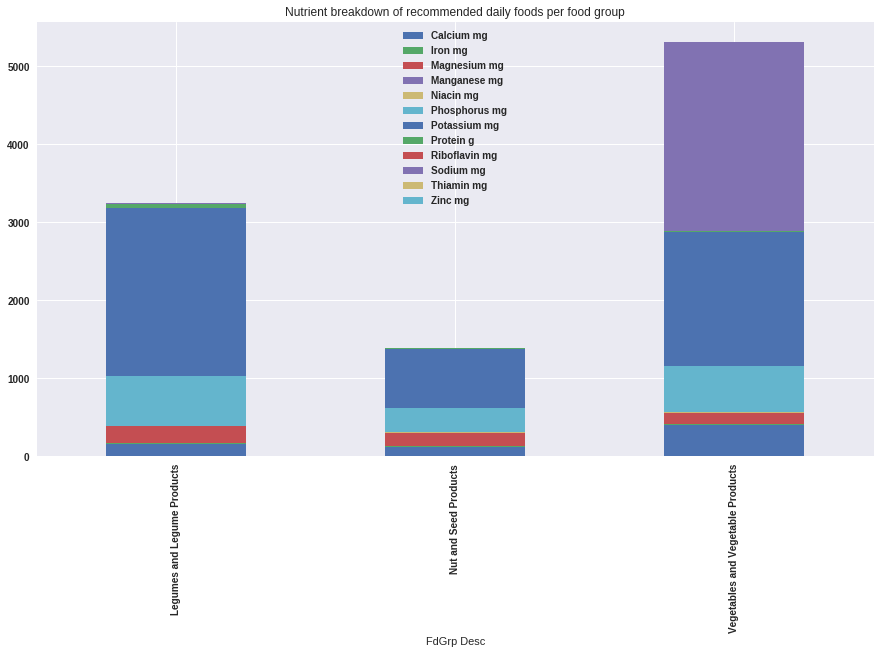

In [383]:
plotcols = [n for n in nutrients_to_check if n!='Age' and n!= 'Gender']
plotcols += ['FdGrp Desc']
p = items[plotcols].groupby('FdGrp Desc').sum().plot.bar(stacked=True, figsize=(15,8))
t = plt.title("Nutrient breakdown of recommended daily foods per food group")

In [377]:
# Nutrients per selected item
# p = items[plotcols].groupby('FdGrp Desc').plot.bar(stacked=True, figsize=(10,7))

In [ ]:
# items[plotcols]
# g = sns.FacetGrid(items[plotcols], row="Shrt Desc x", col=plotcols, margin_titles=True)
# g.map(plt.hist, "total_bill", color="steelblue")


## References

### Data sources

#### Dietary guidelines

https://health.gov/dietaryguidelines/2015/guidelines/chapter-1/key-recommendations/

A Closer Look Inside Healthy Eating Patterns

https://health.gov/dietaryguidelines/2015/guidelines/chapter-1/a-closer-look-inside-healthy-eating-patterns/


#### Food composition database 

[1] https://data.nal.usda.gov/dataset/fooddata-central

https://fdc.nal.usda.gov/data-documentation.html

ABBREV:
 [2] https://data.nal.usda.gov/dataset/composition-foods-raw-processed-prepared-usda-national-nutrient-database-standard-reference-release-28-0

FROM:
https://data.nal.usda.gov/dataset/fooddata-central

DOC:
[3] https://data.nal.usda.gov/system/files/sr28_doc.pdf

#### Food price data

QFHPD Database

[4] https://www.ers.usda.gov/data-products/quarterly-food-at-home-price-database/

Price units and conversion for listed data

[6] https://www.ers.usda.gov/publications/pub-details/?pubid=47567
[6] https://www.ers.usda.gov/webdocs/publications/47564/8516_tb1926_1_.pdf?v=0


#### RDA Data

Nutrient intake

[5] https://health.gov/dietaryguidelines/2015/guidelines/appendix-7/
 Institute of Medicine. Dietary Reference Intakes: The essential guide to nutrient requirements. Washington (DC): The National Academies Press; 2006.
 
 
Other ingredient nutrient values and documentation

https://www.ars.usda.gov/northeast-area/beltsville-md-bhnrc/beltsville-human-nutrition-research-center/food-surveys-research-group/docs/fndds-download-databases/

https://www.ars.usda.gov/ARSUserFiles/80400530/pdf/fndds/2013_2014_FNDDS_Glance.pdf


#### Other data

Google Trends Interest Over Time

https://trends.google.com/trends/explore?date=all&geo=US&q=plant-based


### Math and Programming Resources

Linear programming help

https://www.me.utexas.edu/~jensen/ORMM/models/unit/linear/subunits/blending/index.html

https://developers.google.com/optimization/cp/cp_solver
